# Initializations

In [1]:
import os, shutil, importlib
import utils; importlib.reload(utils)

# os.environ["CUDA_VISIBLE_DEVICES"]=''

import numpy as np
import pandas as pd
import tensorflow as tf
import h5py
import keras

from glob import glob
from PIL import Image
from os.path import join as jp

from keras import layers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image

from sklearn import metrics

from IPython.display import FileLink


%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

Using TensorFlow backend.


Structure data

In [2]:
path = '../data/dogscats/'
utils.struct_dir(path, ['cat', 'dog'])

Directory structure already exists


Setup paths

In [3]:
# path = '../data/dogscats/'
path = '../data/dogscats/sample/'
path_test = path + 'test'
path_train = path + 'train'
path_valid = path + 'valid'
path_submit = '../data/dogscats/models/vgg16/submissions/'
path_checkpoint = '../data/dogscats/models/vgg16/checkpoints/'
path_results = '../data/dogscats/models/vgg16/results/'
path_img_arrays = '../data/dogscats/models/vgg16/img_arrays/'

# Load Model

In [4]:
import vgg16; importlib.reload(vgg16)
from vgg16 import Vgg16

In [5]:
vgg = Vgg16()

Loading model weights


In [6]:
batch_size = 8

Save images in array format

In [7]:
# batches_train = utils.get_batches(path_train, batch_size=batch_size)
# batches_valid = utils.get_batches(path_valid, batch_size=batch_size)

In [8]:
# utils.save_array_h5(path_img_arrays+'train.h5', utils.get_data(path_train))
# utils.save_array_h5(path_img_arrays+'valid.h5', utils.get_data(path_valid))

In [9]:
data_train = utils.load_array_h5(path_img_arrays+'train.h5')
data_valid = utils.load_array_h5(path_img_arrays+'valid.h5')
classes, filenames = utils.get_classes(path)
labels_train = classes[2]
labels_valid = classes[3]

Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


# Model Modifications

## Retrain Last Layer

- Remove last layer and freeze previous layers
- Train last layer
- Evaluate valid set
- Create confusion matrix

### Pop, Freeze and Train

In [10]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 224, 224, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 226, 226, 3)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 224, 224, 64)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 226, 226, 64)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [11]:
vgg.ft(num=2, compile_kwargs={'lr': 0.1})

In [12]:
??vgg.finetune

In [13]:
??vgg.ft

In [13]:
gen = image.ImageDataGenerator()
batches_train = gen.flow(data_train, labels_train, batch_size=batch_size, shuffle=True)
batches_valid = gen.flow(data_valid, labels_valid, batch_size=batch_size, shuffle=True)

In [14]:
??vgg.fit

In [15]:
file_weights = 'weights_2.h5'
callbacks = [ModelCheckpoint(path_checkpoint+file_weights, save_best_only=True)]
vgg.fit(batches_train, batches_valid, nb_epoch=1, callbacks=callbacks)

Epoch 1/1
100/100 [==============================] - 52s - loss: 3.0223 - acc: 0.7600 - val_loss: 1.4003 - val_acc: 0.9000


### Load Checkpoint

In [16]:
vgg.model.load_weights(path_checkpoint+file_weights)

### Evaluation

Evaluate on valid set

In [18]:
print(vgg.model.metrics_names)
vgg.model.evaluate(data_valid, labels_valid, batch_size=batch_size)

100/100 [==============================] - 18s    


['loss', 'acc']

Create confusion matrix

In [19]:
preds = vgg.model.predict_classes(data_valid, batch_size=batch_size)
probs = vgg.model.predict_proba(data_valid, batch_size=batch_size)

100/100 [==============================] - 14s    


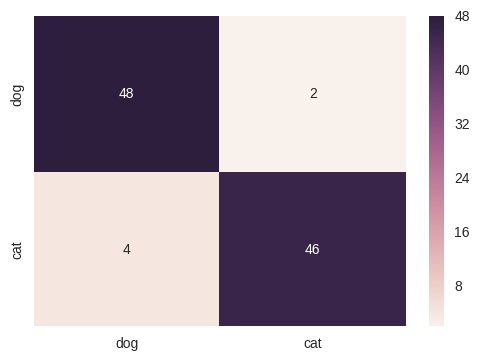

In [20]:
utils.plot_conf_matrix(classes[1], preds, {'cat': 0, 'dog': 1})

## Retrain Multiple

- Finetune final layer (if not done already)
- Find the first dense layer
- Freeze all previous layers and set all layers after D1 to trainable
- Update learning rate (decreaese) and fit model
- Save/Load checkpoint
- Retrain some conv layers
- Save/load checkpoint
- Evaluate

### Find and Un-freeze

In [17]:
idx_fdense = [i for i, layer in enumerate(vgg.model.layers) if type(layer) is layers.Dense][0]

for layer in vgg.model.layers[idx_fdense:]: 
    layer.trainable = True
    print(layer.name, 'Trainable: %s' % layer.trainable)          


dense_1 Trainable: True
dropout_1 Trainable: True
dense_2 Trainable: True
dropout_2 Trainable: True
dense_4 Trainable: True


### Update Learning Rate, Fit Model

In [22]:
??vgg.compile()

In [18]:
# vgg.compile(lr=0.01)
K.set_value(vgg.model.optimizer.lr, 0.001)

In [19]:
file_weights = 'weights_3.h5'
callbacks = [ModelCheckpoint(path_checkpoint+file_weights, save_best_only=True)]
vgg.fit(batches_train, batches_valid, nb_epoch=1, callbacks=callbacks)

Epoch 1/1
100/100 [==============================] - 32s - loss: 2.5293 - acc: 0.8400 - val_loss: 2.0292 - val_acc: 0.8600


### Checkpoint

In [20]:
vgg.model.load_weights(path_checkpoint+file_weights)

### Retrain Conv Layers

In [24]:
idx_conv = [(i, l.name) for i, l in enumerate(vgg.model.layers) if type(l) is layers.Conv2D]
idx_conv

[(2, 'convolution2d_1'),
 (4, 'convolution2d_2'),
 (7, 'convolution2d_3'),
 (9, 'convolution2d_4'),
 (12, 'convolution2d_5'),
 (14, 'convolution2d_6'),
 (16, 'convolution2d_7'),
 (19, 'convolution2d_8'),
 (21, 'convolution2d_9'),
 (23, 'convolution2d_10'),
 (26, 'convolution2d_11'),
 (28, 'convolution2d_12'),
 (30, 'convolution2d_13')]

In [25]:
for layer in vgg.model.layers[26:]: layer.trainable = True

In [26]:
K.set_value(vgg.model.optimizer.lr, 0.001)

In [27]:
file_weights = 'weights_4.h5'
callbacks = [ModelCheckpoint(path_checkpoint+file_weights, save_best_only=True)]
vgg.fit(batches_train, batches_valid, nb_epoch=1, callbacks=callbacks)

Epoch 1/1
100/100 [==============================] - 31s - loss: 1.9279 - acc: 0.8600 - val_loss: 1.3450 - val_acc: 0.8900


### Checkpoint

In [28]:
vgg.model.load_weights(path_checkpoint+file_weights)

### Evaluate

In [29]:
vgg.model.evaluate(data_valid, labels_valid, batch_size=batch_size, )

100/100 [==============================] - 14s    


[1.2834900689125146, 0.90000000000000002]

## Create Submission

In [30]:
??vgg.test

In [32]:
batches_test, probs_test = vgg.test(path_test, batch_size=batch_size)
np.save(path_results+'filenames_test.npy', batches_test.filenames)
np.save(path_results+'probs_test.npy', probs_test)

Found 100 images belonging to 1 classes.


In [34]:
utils.create_submit(batches_test, probs_test[:, 1], clip=(0, 1), fname=path_submit+'submit_1.csv')